# Asset Allocation

1. Step through the data from Jan2017-Dec2017 and at the end of each month using 1y of trailing data:
    - Recompute/rebalance the weights of each of the following portfolios
        - An equally weighted portfolio
        - An inverse volatility weighted portfolio
        - An equal risk contribution portfolio (use **riskparityportfolio** package)
    - **Note:** each portfolio will be rebalanced 12 times at the end-of-day on the following dates: 2016-12-30 for January, 2017-01-31 for February, 2017-02-28 for March, etc.
1. For each strategy, on each rebalance date, calculate backwards looking estimates of the following:
    - asset risk-contributions
    - portfolio volatilities
1. After completing #1, you now have three portfolios that get reblanced 12 times during 2017.  For this part, for each of the strategies, calculate the follow *realized* performance metrics during 2017:
    - portfolio volatility
    - Sharpe ratio
    - calculate/graph the equity curve
    - max draw-down
    - 99% DVaR
1. Throughout your analysis, write some commentary as to why the numbers you are calculating make sense.

**Grading:** 

**#1, #2, #3 (150 points)**

**#4 (50 points)**

In [1]:
import numpy as np
import pandas as pd
import riskparityportfolio as rp

# Load the data from the first sheet to inspect its structure
data = pd.read_excel(r'/Users/yuanhanlim/Desktop/DS & ML/04_asset_allocation/Data.xlsx')

# Define asset categories
categories = ['BCOM Index', 'DXY Index', 'GLD Equity', 'LQD Equity', 'SPY Equity', 'TLT Equity']

# Prepare separate DataFrames for each asset, renaming date columns
bcom_data = data[['Date', 'BCOM Index']]
dxy_data = data[['Date.1', 'DXY Index']].rename(columns={'Date.1': 'Date'})
gld_data = data[['Date.2', 'GLD Equity']].rename(columns={'Date.2': 'Date'})
lqd_data = data[['Date.3', 'LQD Equity']].rename(columns={'Date.3': 'Date'})
spy_data = data[['Date.4', 'SPY Equity']].rename(columns={'Date.4': 'Date'})
tlt_data = data[['Date.5', 'TLT Equity']].rename(columns={'Date.5': 'Date'})

# Collect all asset DataFrames into a list for processing
all_data = [bcom_data, dxy_data, gld_data, lqd_data, spy_data, tlt_data]

# Initialize the merged DataFrame with the first DataFrame (BCOM)
merged_assets = all_data[0]

# Loop through the remaining DataFrames to merge them into one
for asset_frame in all_data[1:]:
    merged_assets = merged_assets.merge(asset_frame, on='Date', how='outer')

# Sort the resulting DataFrame by the Date column
cleaned_data = merged_assets.sort_values(by='Date')

# Print the final DataFrame
cleaned_data = cleaned_data.dropna()

# Set the Date column as the index
cleaned_data.set_index('Date', inplace=True)



/var/folders/79/6xh3y3cd7kl6qqpcykmzhz8r0000gn/T/ipykernel_44773/1774317307.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/yuanhanlim/anaconda3/lib/python3.10/site-packages/riskparityportfolio/sca.py:10: UserWarning: not able to import quadprog. the successive convex optimizer wont work.
  warnings.warn(


## 1. & 2.

In [2]:
from datetime import timedelta


def portfolio_volatility(weights, cov):
    return np.sqrt(np.dot(weights, np.dot(cov, weights.T))) * np.sqrt(252)

def risk_contributions(weights, cov):
    mctar = np.dot(weights, cov * 252) / portfolio_volatility(weights, cov)
    return mctar * weights / portfolio_volatility(weights, cov)
    
# Function to calculate portfolio weights
def compute_portfolio_weights(data_window):
    # 1. Equally weighted portfolio
    num_assets = data_window.shape[1]
    equal_weights = np.repeat(1/num_assets, num_assets)
    
    # 2. Inverse volatility weighted portfolio (Volatility = standard deviation of returns)
    returns = data_window.pct_change().dropna()
    df_covariance_returns = returns.cov()
    volatilities = np.sqrt(np.diagonal(df_covariance_returns))
    inv_vol_weights = 1 / volatilities
    inv_vol_weights /= inv_vol_weights.sum()
    
    # 3. Risk parity
    risk_budget = np.repeat(1/num_assets, num_assets) 
    risk_parity = rp.vanilla.design(df_covariance_returns, risk_budget)

    return equal_weights, inv_vol_weights, risk_parity


# Initialize a dictionary to store the weights at each rebalancing point
portfolio_weights = {
    'date': [],
    'equal_weights': [],
    'inv_vol_weights': [],
    'risk_parity_weights': []
}

# Initialize a dataframe to store the portfolio volatilities at each rebalancing point
df_portfolio_volatilities = pd.DataFrame(columns=['Date', 'equal_weight', 'inverse_volatility', 'risk_parity'])

# Initialize a dataframe to store the risk cotributions at each rebalancing point
df_risk_contributions = pd.DataFrame(columns=['Date', 'equal_weight', 'inverse_volatility', 'risk_parity'])

# Set the starting point for rebalancing at the end of 2016
start_date = pd.to_datetime('2016-12-30')
end_date = pd.to_datetime('2017-12-31')
import numpy as np

# Iterate through each end-of-month date in 2017
for date in pd.date_range(start=start_date, end=end_date, freq='ME'):
    # Use 1 year of trailing data up to the end of each month
    trailing_data = cleaned_data.loc[date - timedelta(days=365):date]
    
    if trailing_data.shape[0] > 0:
        # ------------------------------Portfolio weights----------------------------------------------
        equal_weights, inv_vol_weights, risk_parity_weights = compute_portfolio_weights(trailing_data)
        
        # Store the results (assuming these are lists or arrays)
        portfolio_weights['date'].append(date)
        portfolio_weights['equal_weights'].append(equal_weights)
        portfolio_weights['inv_vol_weights'].append(inv_vol_weights)
        portfolio_weights['risk_parity_weights'].append(risk_parity_weights)

        # ------------------------------Portfolio Volatilities------------------------------------------
        returns = trailing_data.pct_change().dropna()
        df_covariance_returns = returns.cov()

        # Calculate portfolio volatilities using the covariance matrix and portfolio weights
        vol_equal_weight = np.round(portfolio_volatility(equal_weights, df_covariance_returns), 4)
        vol_inv_vol = np.round(portfolio_volatility(inv_vol_weights, df_covariance_returns), 4)
        vol_risk_parity = np.round(portfolio_volatility(risk_parity_weights, df_covariance_returns), 4)

        # Create a new DataFrame for the current date's volatilities
        new_row = pd.DataFrame({
            'Date': [date],
            'equal_weight': [vol_equal_weight],
            'inverse_volatility': [vol_inv_vol],
            'risk_parity': [vol_risk_parity]
        })

        # Append the new row using pd.concat
        df_portfolio_volatilities = pd.concat([df_portfolio_volatilities, new_row], ignore_index=True)

        # ------------------------------Risk Contributions------------------------------------------
        # Calculate risk contributions using the covariance matrix and portfolio weights
        risk_equal_weight = np.round(risk_contributions(equal_weights, df_covariance_returns), 4)
        risk_inv_vol = np.round(risk_contributions(inv_vol_weights, df_covariance_returns), 4)
        risk_risk_parity = np.round(risk_contributions(risk_parity_weights, df_covariance_returns), 4)

        # Create a new DataFrame for the current date's risk contributions
        new_row2 = pd.DataFrame({
            'Date': [date],
            'equal_weight': [risk_equal_weight],
            'inverse_volatility': [risk_inv_vol],
            'risk_parity': [risk_risk_parity]
        })

        # Append the new row using pd.concat
        df_risk_contributions = pd.concat([df_risk_contributions, new_row2], ignore_index=True)


# Convert results to a DataFrame for analysis
weights_df = pd.DataFrame(portfolio_weights)

# Show the results for the first few months
weights_df


/var/folders/79/6xh3y3cd7kl6qqpcykmzhz8r0000gn/T/ipykernel_44773/1759182482.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_portfolio_volatilities = pd.concat([df_portfolio_volatilities, new_row], ignore_index=True)
/var/folders/79/6xh3y3cd7kl6qqpcykmzhz8r0000gn/T/ipykernel_44773/1759182482.py:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_risk_contributions = pd.concat([df_risk_contributions, new_row2], ignore_index=True)


,date,equal_weights,inv_vol_weights,risk_parity_weights
0,2016-12-31,"[0.16666666666666666, 0.16666666666666666, 0.1...","[0.11022963949282784, 0.22084633173956084, 0.1...","[0.10255655113089689, 0.3330290888875244, 0.10..."
1,2017-01-31,"[0.16666666666666666, 0.16666666666666666, 0.1...","[0.11188671491555459, 0.21294929023203363, 0.1...","[0.10258150651371885, 0.3400788087721643, 0.09..."
2,2017-02-28,"[0.16666666666666666, 0.16666666666666666, 0.1...","[0.11127195736117548, 0.21324628760880224, 0.1...","[0.10464922630824822, 0.34548337329798445, 0.0..."
3,2017-03-31,"[0.16666666666666666, 0.16666666666666666, 0.1...","[0.1133564145761706, 0.21362024709591726, 0.10...","[0.10504566697213248, 0.34470606398009723, 0.1..."
4,2017-04-30,"[0.16666666666666666, 0.16666666666666666, 0.1...","[0.1186844466258585, 0.2117925031682334, 0.111...","[0.11083939325805066, 0.3423123178138212, 0.09..."
5,2017-05-31,"[0.16666666666666666, 0.16666666666666666, 0.1...","[0.12040721119614857, 0.2084510495726908, 0.11...","[0.1107242559867504, 0.3376534948271809, 0.098..."
6,2017-06-30,"[0.16666666666666666, 0.16666666666666666, 0.1...","[0.11755019164821685, 0.21169384801177596, 0.1...","[0.11024180426299122, 0.36050546645285975, 0.1..."
7,2017-07-31,"[0.16666666666666666, 0.16666666666666666, 0.1...","[0.12186645580713353, 0.20792413868401, 0.1200...","[0.11015246205012749, 0.35585400312024146, 0.1..."
8,2017-08-31,"[0.16666666666666666, 0.16666666666666666, 0.1...","[0.12210117413074963, 0.20807599179307557, 0.1...","[0.1093805014836576, 0.35889377231244735, 0.11..."
9,2017-09-30,"[0.16666666666666666, 0.16666666666666666, 0.1...","[0.1248739472223464, 0.2020634783549001, 0.114...","[0.1118756128747279, 0.33076480300087874, 0.10..."


In [3]:
df_portfolio_volatilities

,Date,equal_weight,inverse_volatility,risk_parity
0,2016-12-31,0.0512,0.0418,0.0381
1,2017-01-31,0.0494,0.0399,0.0345
2,2017-02-28,0.0479,0.0389,0.0329
3,2017-03-31,0.0479,0.0394,0.0336
4,2017-04-30,0.0470,0.0392,0.0332
5,2017-05-31,0.0465,0.0389,0.0328
6,2017-06-30,0.0443,0.0372,0.0310
7,2017-07-31,0.0427,0.0364,0.0304
8,2017-08-31,0.0421,0.0356,0.0295
9,2017-09-30,0.0399,0.0335,0.0287


#### Equal weight allocation has given us the highest portfolio volatility and risk parity allocation resulted in lowest portfolio volatility in EVERY MONTH. This result is convinving and we can proceed to the next step 

In [4]:
 df_risk_contributions

,Date,equal_weight,inverse_volatility,risk_parity
0,2016-12-31,"[0.2741, -0.0438, 0.3269, 0.1124, 0.1107, 0.2197]","[0.1612, 0.0005, 0.1999, 0.3036, 0.0902, 0.2447]","[0.1666, 0.1667, 0.1667, 0.1666, 0.1667, 0.1667]"
1,2017-01-31,"[0.2644, -0.0713, 0.3655, 0.1201, 0.0732, 0.248]","[0.1632, -0.0449, 0.2234, 0.3155, 0.0799, 0.263]","[0.1666, 0.1667, 0.1667, 0.1666, 0.1667, 0.1667]"
2,2017-02-28,"[0.255, -0.07, 0.3523, 0.1231, 0.0734, 0.2662]","[0.1567, -0.0503, 0.2274, 0.3073, 0.0896, 0.2692]","[0.1666, 0.1667, 0.1667, 0.1666, 0.1667, 0.1667]"
3,2017-03-31,"[0.2487, -0.0626, 0.334, 0.13, 0.0743, 0.2756]","[0.1606, -0.0431, 0.224, 0.3026, 0.0932, 0.2627]","[0.1666, 0.1667, 0.1667, 0.1666, 0.1667, 0.1667]"
4,2017-04-30,"[0.2262, -0.0607, 0.335, 0.1359, 0.0747, 0.289]","[0.1573, -0.0452, 0.2339, 0.3001, 0.0913, 0.2626]","[0.1666, 0.1667, 0.1667, 0.1666, 0.1667, 0.1667]"
5,2017-05-31,"[0.2223, -0.0614, 0.3346, 0.1377, 0.0668, 0.3001]","[0.1598, -0.0475, 0.2346, 0.2992, 0.086, 0.2678]","[0.1666, 0.1667, 0.1667, 0.1666, 0.1667, 0.1667]"
6,2017-06-30,"[0.2245, -0.0732, 0.3061, 0.1429, 0.0997, 0.3001]","[0.1571, -0.0609, 0.2218, 0.2851, 0.1425, 0.2545]","[0.1666, 0.1666, 0.1668, 0.1666, 0.1667, 0.1667]"
7,2017-07-31,"[0.2223, -0.0727, 0.3025, 0.1456, 0.1043, 0.298]","[0.162, -0.0603, 0.2199, 0.2821, 0.1446, 0.2517]","[0.1666, 0.1666, 0.1668, 0.1666, 0.1667, 0.1667]"
8,2017-08-31,"[0.2271, -0.0789, 0.3141, 0.1419, 0.1044, 0.2915]","[0.1666, -0.0719, 0.2306, 0.2856, 0.1372, 0.252]","[0.1666, 0.1667, 0.1667, 0.1666, 0.1667, 0.1667]"
9,2017-09-30,"[0.2206, -0.0773, 0.3468, 0.1481, 0.0524, 0.3094]","[0.1706, -0.0595, 0.2415, 0.2889, 0.1051, 0.2534]","[0.1666, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]"


#### Risk_parity allocation has given us equal risk contribution in every index, which is expected by the way we construct it. 

## 3. 

In [5]:
df_returns_performance = cleaned_data.pct_change().dropna()

# Create an empty DataFrame for the performance results
df_performance = pd.DataFrame(index=cleaned_data.index)

# Start by looping through each row in the weights DataFrame (monthly)
for i in range(len(weights_df)-1):
    # Get the start and end date for the current month
    start_date = weights_df.loc[i, 'date']
    end_date = weights_df.loc[i+1, 'date'] if i+1 < len(weights_df) else df_returns_performance.index[-1]

    # Extract the weights for this month
    equal_weights = weights_df.loc[i, 'equal_weights']
    inv_vol_weights = weights_df.loc[i, 'inv_vol_weights']
    risk_parity_weights = weights_df.loc[i, 'risk_parity_weights']
    # Filter daily returns between start and end date
    daily_returns = df_returns_performance.loc[start_date:end_date]
    
    # Calculate daily returns for each strategy
    df_performance.loc[start_date:end_date, 'equal_weight_ret'] = (equal_weights * daily_returns).sum(axis=1)
    df_performance.loc[start_date:end_date, 'inv_volatility_ret'] = (inv_vol_weights * daily_returns).sum(axis=1)
    df_performance.loc[start_date:end_date, 'risk_parity_ret'] = (risk_parity_weights * daily_returns).sum(axis=1)

# Drop the NaNs so that there'll only be 2017 performance
df_performance = df_performance.dropna()

## Annualized Return

In [6]:
def annualized_return(ret):
    return (((1 + ret).prod()) ** (252 / len(ret))) - 1
     

In [7]:
df_annualized_return = \
    pd.DataFrame({
        'equal_weight': [annualized_return(df_performance['equal_weight_ret'])],
        'inverse_volatility': [annualized_return(df_performance['inv_volatility_ret'])],
        'risk_parity': [annualized_return(df_performance['risk_parity_ret'])],
    })
df_annualized_return
     

,equal_weight,inverse_volatility,risk_parity
0,0.054295,0.041313,0.022561


#### Equal weight has given us the highest return while risk parity has the lowest, but higher return comes with higher risk. So we shall proceed to check if equal weight has higher realized vol than risk parity 

## Realized Vol

In [8]:
def realized_vol(ret):
    return ret.std() * np.sqrt(252)

In [9]:

# realized volatility
df_realized_vol = \
    pd.DataFrame({
        'equal_weight': [realized_vol(df_performance['equal_weight_ret'])],
        'inverse_volatility': [realized_vol(df_performance['inv_volatility_ret'])],
        'risk_parity': [realized_vol(df_performance['risk_parity_ret'])],
    })
df_realized_vol

,equal_weight,inverse_volatility,risk_parity
0,0.036438,0.030398,0.026459


#### As expected, equal weight has the highest anualized realized vol

## Sharpe Ratio

In [10]:
def sharpe_ratio(ret):
    return (ret.mean() / ret.std()) * np.sqrt(252)

In [11]:
df_sharpe = \
    pd.DataFrame({
        'equal_weight': [sharpe_ratio(df_performance['equal_weight_ret'])],
        'inverse_volatility': [sharpe_ratio(df_performance['inv_volatility_ret'])],
        'risk_parity': [sharpe_ratio(df_performance['risk_parity_ret'])],
    })
df_sharpe

,equal_weight,inverse_volatility,risk_parity
0,1.469302,1.347008,0.856418


#### Considering both risk and return, equal weight still offers the most lucrative reward as we can see that it has given us the hgiest sharpe ratio 

## Equity Curve

In [12]:
df_performance['equal_weight_equity'] = (1 + df_performance['equal_weight_ret']).cumprod()
df_performance['inverse_volatility_equity'] = (1 + df_performance['inv_volatility_ret']).cumprod()
df_performance['risk_parity_equity'] = (1 + df_performance['risk_parity_ret']).cumprod()
df_performance.head().T

Date,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-09
equal_weight_ret,0.002313,0.004104,0.004723,-0.002196,0.000059
inv_volatility_ret,0.002909,0.002991,0.003061,-0.001794,0.000136
risk_parity_ret,0.004160,0.002029,0.000898,-0.000202,-0.000497
equal_weight_equity,1.002313,1.006427,1.011181,1.008961,1.009020
inverse_volatility_equity,1.002909,1.005908,1.008987,1.007177,1.007314
risk_parity_equity,1.004160,1.006197,1.007100,1.006897,1.006396


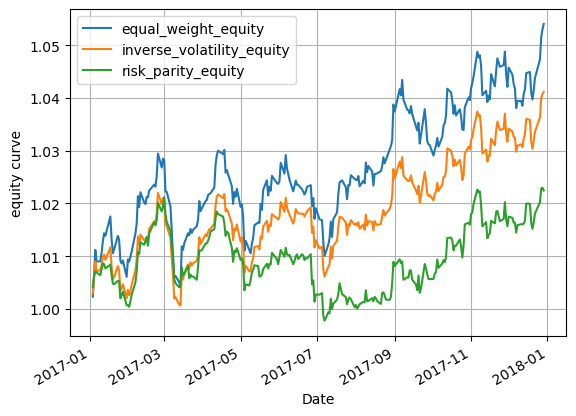

In [13]:
df_performance.plot(
    y=['equal_weight_equity', 'inverse_volatility_equity', 'risk_parity_equity'],
    ylabel='equity curve',
    grid=True,
);

#### The reason that risk parity underperformed (vs the other 2 strategies) over 2017 was that during the time when market rally, it didn't have enough moementum to catch up with the other 2 even though it outperformed during market downturn. Thus, we can conclude that if the market rally most of the time in a year, risk parity will underperform vs the simple equal weight strategy. 

## Max Drawdown

In [14]:
def draw_down(equity_curve):
    return (equity_curve - equity_curve.cummax()) / equity_curve.cummax()

In [15]:
df_performance['equal_weight_draw_down'] = draw_down(df_performance['equal_weight_equity'])
df_performance['inverse_volatility_draw_down'] = draw_down(df_performance['inv_volatility_ret'])
df_performance['risk_parity_draw_down'] = draw_down(df_performance['risk_parity_equity'])
df_performance.head().T

Date,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-09
equal_weight_ret,0.002313,0.004104,0.004723,-0.002196,0.000059
inv_volatility_ret,0.002909,0.002991,0.003061,-0.001794,0.000136
risk_parity_ret,0.004160,0.002029,0.000898,-0.000202,-0.000497
equal_weight_equity,1.002313,1.006427,1.011181,1.008961,1.009020
inverse_volatility_equity,1.002909,1.005908,1.008987,1.007177,1.007314
risk_parity_equity,1.004160,1.006197,1.007100,1.006897,1.006396
equal_weight_draw_down,0.000000,0.000000,0.000000,-0.002196,-0.002137
inverse_volatility_draw_down,0.000000,0.000000,0.000000,-1.586183,-0.955653
risk_parity_draw_down,0.000000,0.000000,0.000000,-0.000202,-0.000699


In [16]:
# max draw down
df_max_draw_downs = \
    pd.DataFrame({
        'equal_weight': [df_performance['equal_weight_draw_down'].min()],
        'inverse_volatility': [df_performance['inv_volatility_ret'].min()],
        'risk_parity': [df_performance['risk_parity_draw_down'].min()],
    })
df_max_draw_downs

,equal_weight,inverse_volatility,risk_parity
0,-0.024599,-0.005136,-0.02291


#### Even though the Max Drawdown of risk_parity is lower than equal weight, it's still surprising that the values were actually very close to each other. It might be becasue that the assets are highly correlated 

In [22]:
correlation_matrix = cleaned_data.corr()

# Display the correlation matrix
correlation_matrix

,BCOM Index,DXY Index,GLD Equity,LQD Equity,SPY Equity,TLT Equity
BCOM Index,1.000000,-0.168715,-0.048180,0.182944,-0.147958,-0.095320
DXY Index,-0.168715,1.000000,-0.428944,-0.441808,-0.136574,-0.396193
GLD Equity,-0.048180,-0.428944,1.000000,0.807679,0.426088,0.649057
LQD Equity,0.182944,-0.441808,0.807679,1.000000,0.412961,0.698360
SPY Equity,-0.147958,-0.136574,0.426088,0.412961,1.000000,-0.178338
TLT Equity,-0.095320,-0.396193,0.649057,0.698360,-0.178338,1.000000


#### No wonder. As we can see GLD Equity is highly correlatad to other equitys especially with the Investment Grade Corporate Bond ETF (80%), reducing the diversification benefits that typically mitigate drawdowns in such a strategy.

## 99% DVar

In [17]:
def dvar(ret):
    return np.percentile(ret, 0.01)

In [18]:
df_dvar= \
    pd.DataFrame({
        'equal_weight': [dvar(df_performance['equal_weight_ret'])],
        'inverse_volatility': [dvar(df_performance['inv_volatility_ret'])],
        'risk_parity': [dvar(df_performance['risk_parity_ret'])],
    })
df_dvar
     

,equal_weight,inverse_volatility,risk_parity
0,-0.006343,-0.005127,-0.005644


#### As we can see, DVar for risk_parity is pretty high as well. 